# Qiskit Assignment 3
## Multiple Qubits, Entanglement, and Teleportation

### Learning Objectives
1. Understand the role of endianness in multi-qubit quantum circuits
2. Construct circuits with multiple qubits and entangled states
3. Solve a teleportation scenario

**NAME**: REPLACE WITH YOUR NAME

**STUDENT ID**: REPLACE WITH YOUR STUDENT ID

In [1]:
# Import Qiskit and other needed packages
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit_textbook.tools import array_to_latex
import matplotlib.pyplot as plt
import random
import numpy as np
import pprint

#### Task 1 - Endianness and Multi-Qubit Circuits (10 pts)

Qiskit uses a little endian convention for qubit ordering different from many textbooks and the lecture slides.
 
Consider a circuit in the state $$\Psi=|0001\rangle$$

According to the convention used in lecture, the least significant qubit of the circuit, $q_0$, holds the state of the leftmost digit of $\Psi$, $|0\rangle$. In general, this convention can be represented as $$|q_0,q_1,...,q_{n-1},q_n\rangle$$

However, Qiskit interprets the rightmost digit, $|1\rangle$, as the state of the least significant qubit. This is the standard ordering of binary bitstrings, but it leads to a non-standard tensor product order ([source](https://qiskit.org/documentation/tutorials/circuits/1_getting_started_with_qiskit.html#OpenQASM-backend)). Hence, the general form of the Qiskit ordering goes $$|q_n,q_{n-1},...,q_1,q_0\rangle$$

We want to utilize the power of Qiskit for building and running quantum circuits while also remaining consistent with our notation and tensor product math. In this class, we'll stick to the big endian convention consistent with lectures. Qiskit provides two functions that can help.

We can use the [`reverse_bits()`](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.reverse_bits.html#qiskit.circuit.QuantumCircuit.reverse_bits) method to return a quantum circuit with qubit ordering flipped completely. Recall that we used this method in the first qiskit assignment.
- Pros: good for running a job and displaying the counts and/or histogram in big endian notation
- Cons: vertically flips circuit which can confuse interpretation of circuit diagram; creates separate circuit

We can also use the Statevector class's [`reverse_qargs()`](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Statevector.reverse_qargs.html#qiskit-quantum-info-statevector-reverse-qargs) method to display the state of a multi-qubit circuit in big endian notation.
- Pros: keeps diagram ordering as we'd expect; does not create separate circuit
- Cons: does not change how counts are represented in job results or histogram counts

To check your understanding of qubit ordering in Qiskit, consider the following code which returns a circuit and its statevector, $|1+\rangle$. Modify the code so the statevector returned is the big endian form, $|+1\rangle$, without adding or modifying gates.

In [2]:
def endianness():
    qc = QuantumCircuit(2,2)
    qc.h(0)
    qc.x(1)
    ket = Statevector.from_instruction(qc)
    # BEGIN SOLUTION
    ket = ket.reverse_qargs()
    # END SOLUTION
    return qc, ket

array_to_latex(endianness()[1], pretext="\\text{Task 1 SV} = ")

<IPython.core.display.Math object>

In [3]:
def testGates1():
    ops = len(endianness()[0].count_ops()) == 2
    h = endianness()[0].count_ops()['h'] == 1
    x = endianness()[0].count_ops()['x'] == 1
    return ops and h and x

testGates1()

True

In [4]:
def testGates1():
    ops = len(endianness()[0].count_ops()) == 2
    h = endianness()[0].count_ops()['h'] == 1
    x = endianness()[0].count_ops()['x'] == 1
    return ops and h and x

def testSv1():
    return endianness()[1].equiv(Statevector([0,1/np.sqrt(2),0,1/np.sqrt(2)]))

testSv1() and testGates1()

True

#### Task 2 (2A, 2B) - Multiple Qubit Circuits (30 pts)

#### Task 2A
Run the following cell. Return a circuit from `multi_qubit_a` that produces the following target state on measurement. It's okay if your resulting state is equivalent up to a global phase. Your qubits must start in state $|00\rangle$ i.e. no initializations are allowed.

In [5]:
array_to_latex([-1j/2, 1/2, -1/2, -1j/2], pretext="\\text{2A Target Statevector} = ")

<IPython.core.display.Math object>

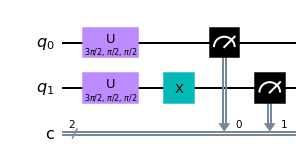

In [6]:
def multi_qubit_a():
    # BEGIN SOLUTION
    # hint: recognize the target state is tensor factorable so this is not an entangled state.
    # So we can find what states the qubits need to be in individually.
    # If we prepare |0> on qubit zero and |1> on qubit one,
    # can use outer product from lecture 01 to obtain the matrix necessary to make this transformation
    # they've practiced using the U gate in q1 assignment so can solve for the corresponding U gate parameters.
    #
    qc = QuantumCircuit(2,2)
    # primary solution - U gate
    phi = 3*np.pi/2
    theta = np.pi/2
    lamda = np.pi/2
    qc.u(phi,theta,lamda,0)
    qc.u(phi,theta,lamda,1)
    qc.x(1)
#     alternate solution - P, H, and X gates
#     qc_a.h(0)
#     qc_a.p(3*np.pi/2,0)
#     qc_a.h(1)
#     qc_a.p(3*np.pi/2,1)
#     qc_a.x(1)

    qc.measure(0,0)
    qc.measure(1,1)
    return qc
    # END SOLUTION

multi_qubit_a().draw(output='mpl')

In [7]:
def testNoInitializations_2a():
    ops = multi_qubit_a().count_ops()
    return not 'initialize' in ops
    
testNoInitializations_2a()

True

In [8]:
def testMeasurements_2a():
    ops = multi_qubit_a().count_ops()
    return 'measure' in ops and ops['measure'] == 2

testMeasurements_2a()

True

In [9]:
def testAmplitudes_2a():
    qc = multi_qubit_a()
    qc.remove_final_measurements()
    ket = Statevector.from_instruction(qc).reverse_qargs()
    return Statevector([-1j/2, 1/2, -1/2, -1j/2]).equiv(ket)

testAmplitudes_2a()

True

#### Task 2B
Run the following cell. Return a circuit from `multi_qubit_b` that produces the following target state on measurement. It's okay if your resulting state is equivalent up to a global phase. Your qubits must start in state $|00\rangle$ i.e. no initializations are allowed.

In [10]:
array_to_latex([1/(2**(.5)), 0, 0, -1/(2**(.5))], pretext="\\text{2B Target Statevector} = ")

<IPython.core.display.Math object>

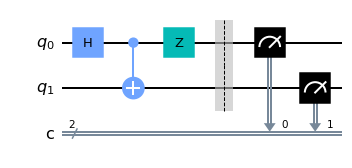

In [11]:
def multi_qubit_b():
    # BEGIN SOLUTION
    # hint: recognize the target state is a bell state; it's entangled and not tensor factorable
    # bell states are created in similar ways to each other, there is an example in lecture 10
    # on teleportation. the tensor of Z and I produces the desired negative
    qc = QuantumCircuit(2,2)
    qc.h(0)
    qc.cnot(0,1)
    qc.z(0)
    qc.barrier()
    qc.measure(0,0)
    qc.measure(1,1)
    return qc
    # END SOLUTION

multi_qubit_b().draw(output='mpl')

In [12]:
def testNoInitializations_2b():
    ops = multi_qubit_b().count_ops()
    return not 'initialize' in ops
    
testNoInitializations_2b()

True

In [13]:
def testMeasurements_2b():
    ops = multi_qubit_b().count_ops()
    return 'measure' in ops and ops['measure'] == 2

testMeasurements_2b()

True

In [14]:
def testAmplitudes_2b():
    qc = multi_qubit_b()
    qc.remove_final_measurements()
    ket = Statevector.from_instruction(qc).reverse_qargs()
    return Statevector([1/(2**(.5)), 0, 0, -1/(2**(.5))]).equiv(ket)

testAmplitudes_2b()

True

#### Task 3 (3A, 3B) - What's in the box? (30 pts)

Build a circuit that figures out what rotation is done by an oracle. 

**README**: Your solutions to 3A and 3B may not use conditional statements to dynamically pick gates according to the input or otherwise attempt to influence the oracle. In other words, the only gate that may vary between runs is the oracle, and do not use the parameter `r` in any code you write. Solutions not adhering to these guidelines will be severely penalized. As usual, we reserve the right to manually inspect your code.

#### Task 3A
The oracle promises to be **I** or **Z**. Return a circuit from `whats_in_box_a` such that 
- measurement yields either $|0\rangle$ or $|1\rangle$
- the probability of measuring each state is correlated perfectly with the gates returned by the oracle
- example: if you return $|1\rangle$ for an oracle of Z, the probability of seeing $|1\rangle$ given an oracle of I should be 0.

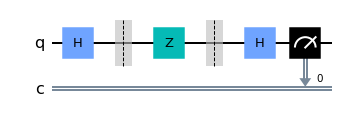

In [15]:
def oracle_a(qc, r=None):
    if r is None:
        r = random.uniform(0, 1)
    qc.i(0) if r > 0.5 else qc.z(0)
    return qc

def whats_in_box_a(r=None):
    # BEGIN SOLUTION
    # hint: use I:0, Z:1
    qc = QuantumCircuit(1,1)
    qc.h(0)
    # END SOLUTION
    qc.barrier()
    qc = oracle_a(qc,r)
    qc.barrier()
    # BEGIN SOLUTION
    qc.h(0)
    qc.measure(0,0)
    # END SOLUTION
    return qc

qc3a = whats_in_box_a()
qc3a.draw(output='mpl')

In [16]:
qc3a.remove_final_measurements()
array_to_latex(Statevector.from_instruction(qc3a), pretext="\\text{3A last run} = ")

<IPython.core.display.Math object>

In [17]:
def testValidateRulesA():
    qc_z = whats_in_box_a(0)
    qc_i = whats_in_box_a(1)
    ops_z = qc_z.count_ops()
    ops_i = qc_i.count_ops()
    if abs(len(ops_z) - len(ops_i)) > 1:
        return False
    for (k, v) in ops_z.items():
        if k in ops_i:
            if v != ops_i[k]:
                if abs(ops_i[k] - v) > 0 and (k != 'z' and k != 'i'):
                    return False
    try:
        nz = ops_i['z']
    except KeyError:
        nz = 0
    try:
        ni = ops_z['id']
    except KeyError:
        ni = 0
    return ops_i['id'] - ni == 1 and ops_z['z'] - nz == 1
    
testValidateRulesA()

True

In [18]:
def testValidateRulesA():
    qc_z = whats_in_box_a(0)
    qc_i = whats_in_box_a(1)
    ops_z = qc_z.count_ops()
    ops_i = qc_i.count_ops()
    if abs(len(ops_z) - len(ops_i)) > 1:
        return False
    for (k, v) in ops_z.items():
        if k in ops_i:
            if v != ops_i[k]:
                if abs(ops_i[k] - v) > 0 and (k != 'z' and k != 'i'):
                    return False
    try:
        nz = ops_i['z']
    except KeyError:
        nz = 0
    try:
        ni = ops_z['id']
    except KeyError:
        ni = 0
    return ops_i['id'] - ni == 1 and ops_z['z'] - nz == 1

def testZOracleA():
    sim = BasicAer.get_backend("qasm_simulator")
    shots = 10
    qc = whats_in_box_a(0)
    job = execute(qc, sim, shots=shots)
    counts = job.result().get_counts()
    res = counts['0'] if '0' in counts else counts['1']
    return len(counts) == 1 and res == shots and testValidateRulesA()

testZOracleA()

True

In [19]:
def testValidateRulesA():
    qc_z = whats_in_box_a(0)
    qc_i = whats_in_box_a(1)
    ops_z = qc_z.count_ops()
    ops_i = qc_i.count_ops()
    if abs(len(ops_z) - len(ops_i)) > 1:
        return False
    for (k, v) in ops_z.items():
        if k in ops_i:
            if v != ops_i[k]:
                if abs(ops_i[k] - v) > 0 and (k != 'z' and k != 'i'):
                    return False
    try:
        nz = ops_i['z']
    except KeyError:
        nz = 0
    try:
        ni = ops_z['id']
    except KeyError:
        ni = 0
    return ops_i['id'] - ni == 1 and ops_z['z'] - nz == 1

def testIOracleA():
    sim = BasicAer.get_backend("qasm_simulator")
    shots = 10
    qc = whats_in_box_a(1)
    job = execute(qc, sim, shots=shots)
    counts = job.result().get_counts()
    res = counts['0'] if '0' in counts else counts['1']
    return len(counts) == 1 and res == shots and testValidateRulesA()

testIOracleA()

True

In [20]:
def testValidateRulesA():
    qc_z = whats_in_box_a(0)
    qc_i = whats_in_box_a(1)
    ops_z = qc_z.count_ops()
    ops_i = qc_i.count_ops()
    if abs(len(ops_z) - len(ops_i)) > 1:
        return False
    for (k, v) in ops_z.items():
        if k in ops_i:
            if v != ops_i[k]:
                if abs(ops_i[k] - v) > 0 and (k != 'z' and k != 'i'):
                    return False
    try:
        nz = ops_i['z']
    except KeyError:
        nz = 0
    try:
        ni = ops_z['id']
    except KeyError:
        ni = 0
    return ops_i['id'] - ni == 1 and ops_z['z'] - nz == 1

def testIOracleA():
    sim = BasicAer.get_backend("qasm_simulator")
    shots = 10
    qc = whats_in_box_a(1)
    job = execute(qc, sim, shots=shots)
    counts = job.result().get_counts()
    res = counts['0'] if '0' in counts else counts['1']
    return len(counts) == 1 and res == shots and testValidateRulesA()

def testZOracleA():
    sim = BasicAer.get_backend("qasm_simulator")
    shots = 10
    qc = whats_in_box_a(0)
    job = execute(qc, sim, shots=shots)
    counts = job.result().get_counts()
    res = counts['0'] if '0' in counts else counts['1']
    return len(counts) == 1 and res == shots and testValidateRulesA()

def testMixedOracleA():
    passing_both = all([testZOracleA() and testIOracleA() for i in range(10)])
    if not passing_both:
        return False
    shots = 100
    sim = BasicAer.get_backend("qasm_simulator")
    qc_z = whats_in_box_a(0)
    job_z = execute(qc_z, sim, shots=shots)
    counts_z = job_z.result().get_counts()
    qc_i = whats_in_box_a(1)
    job_i = execute(qc_i, sim, shots=shots)
    counts_i = job_i.result().get_counts()
    are_different_values = ('1' in counts_z) if '0' in counts_i else ('0' in counts_z)
    return are_different_values

testMixedOracleA()

True

#### Task 3B
The oracle promises to be **I**, **X**, **Y**, or **Z**. Return a circuit from `whats_in_box_b` such that
- measurement yields either $|00\rangle$, $|01\rangle$, $|10\rangle$, or $|11\rangle$
- the probability of seeing each state is correlated perfectly with respective individual gates returned by the oracle
- example: if you return $|01\rangle$ for an oracle of Z, the probability of seeing $|01\rangle$ given any other gate should be 0

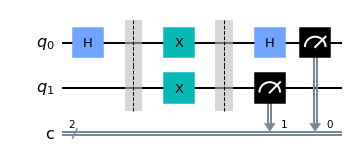

In [21]:
def oracle_b(qc, r=None):
    if r is None:
        r = random.uniform(0, 1)
    if r < 0.25:
        qc.i(0)
        qc.i(1)
    elif r < 0.5:
        qc.x(0)
        qc.x(1)
    elif r < 0.75:
        qc.y(0)
        qc.y(1)
    else:
        qc.z(0)
        qc.z(1)
    return qc

def whats_in_box_b(r=None):
    # BEGIN SOLUTION
    # hint: use I:00, X:01, Y:11, Z:10
    qc = QuantumCircuit(2,2)
    qc.h(0)
    # END SOLUTION
    qc.barrier()
    qc = oracle_b(qc,r)
    qc.barrier()
    # BEGIN SOLUTION
    qc.h(0)
    qc.measure(0,0)
    qc.measure(1,1)
    # END SOLUTION
    return qc

qc3b = whats_in_box_b()
qc3b.draw(output='mpl')

In [22]:
qc3b.remove_final_measurements()
array_to_latex(Statevector.from_instruction(qc3b).reverse_qargs(), pretext="\\text{3B last run} = ")

<IPython.core.display.Math object>

In [23]:
def testValidateRulesB():
    qc_i = whats_in_box_b(0)
    qc_x = whats_in_box_b(0.3)
    qc_y = whats_in_box_b(0.6)
    qc_z = whats_in_box_b(1)
    qcs = [qc_i, qc_x, qc_y, qc_z]
    gates = ['i','x','y','z']

                
    for i,a in enumerate(qcs):
        for j,b in enumerate(qcs):
            if i == j:
                continue
            elif abs(len(a.count_ops()) - len(b.count_ops())) > 1:
                return False
            for ka, va in a.count_ops().items():
                if ka in b.count_ops():
                    if abs(b.count_ops()[ka] - va) > 0 and (ka != gates[i]):
                        return False
                
    return True
    
testValidateRulesB()

True

In [24]:
def testValidateRulesB():
    qc_i = whats_in_box_b(0)
    qc_x = whats_in_box_b(0.3)
    qc_y = whats_in_box_b(0.6)
    qc_z = whats_in_box_b(1)
    qcs = [qc_i, qc_x, qc_y, qc_z]
    gates = ['i','x','y','z']            
    for i,a in enumerate(qcs):
        for j,b in enumerate(qcs):
            if i == j:
                continue
            elif abs(len(a.count_ops()) - len(b.count_ops())) > 1:
                return False
            for ka, va in a.count_ops().items():
                if ka in b.count_ops():
                    if abs(b.count_ops()[ka] - va) > 0 and (ka != gates[i]):
                        return False           
    return True

def testIOracleB():
    sim = BasicAer.get_backend("qasm_simulator")
    shots = 10
    qc = whats_in_box_b(0)
    job = execute(qc, sim, shots=shots)
    counts = job.result().get_counts()
    res = -1
    for state in ['00','01','10','11']:
        if state in counts:
            res = counts[state]
            break
    return len(counts) == 1 and res == shots and testValidateRulesB()

testIOracleB()

True

In [25]:
def testValidateRulesB():
    qc_i = whats_in_box_b(0)
    qc_x = whats_in_box_b(0.3)
    qc_y = whats_in_box_b(0.6)
    qc_z = whats_in_box_b(1)
    qcs = [qc_i, qc_x, qc_y, qc_z]
    gates = ['i','x','y','z']            
    for i,a in enumerate(qcs):
        for j,b in enumerate(qcs):
            if i == j:
                continue
            elif abs(len(a.count_ops()) - len(b.count_ops())) > 1:
                return False
            for ka, va in a.count_ops().items():
                if ka in b.count_ops():
                    if abs(b.count_ops()[ka] - va) > 0 and (ka != gates[i]):
                        return False           
    return True

def testXOracleB():
    sim = BasicAer.get_backend("qasm_simulator")
    shots = 10
    qc = whats_in_box_b(0.3)
    job = execute(qc, sim, shots=shots)
    counts = job.result().get_counts()
    res = -1
    for state in ['00','01','10','11']:
        if state in counts:
            res = counts[state]
            break
    return len(counts) == 1 and res == shots and testValidateRulesB()

testXOracleB()

True

In [26]:
def testValidateRulesB():
    qc_i = whats_in_box_b(0)
    qc_x = whats_in_box_b(0.3)
    qc_y = whats_in_box_b(0.6)
    qc_z = whats_in_box_b(1)
    qcs = [qc_i, qc_x, qc_y, qc_z]
    gates = ['i','x','y','z']            
    for i,a in enumerate(qcs):
        for j,b in enumerate(qcs):
            if i == j:
                continue
            elif abs(len(a.count_ops()) - len(b.count_ops())) > 1:
                return False
            for ka, va in a.count_ops().items():
                if ka in b.count_ops():
                    if abs(b.count_ops()[ka] - va) > 0 and (ka != gates[i]):
                        return False           
    return True

def testYOracleB():
    sim = BasicAer.get_backend("qasm_simulator")
    shots = 10
    qc = whats_in_box_b(1)
    job = execute(qc, sim, shots=shots)
    counts = job.result().get_counts()
    res = -1
    for state in ['00','01','10','11']:
        if state in counts:
            res = counts[state]
            break
    return len(counts) == 1 and res == shots and testValidateRulesB()

testYOracleB()

True

In [27]:
def testValidateRulesB():
    qc_i = whats_in_box_b(0)
    qc_x = whats_in_box_b(0.3)
    qc_y = whats_in_box_b(0.6)
    qc_z = whats_in_box_b(1)
    qcs = [qc_i, qc_x, qc_y, qc_z]
    gates = ['i','x','y','z']            
    for i,a in enumerate(qcs):
        for j,b in enumerate(qcs):
            if i == j:
                continue
            elif abs(len(a.count_ops()) - len(b.count_ops())) > 1:
                return False
            for ka, va in a.count_ops().items():
                if ka in b.count_ops():
                    if abs(b.count_ops()[ka] - va) > 0 and (ka != gates[i]):
                        return False           
    return True

def testZOracleB():
    sim = BasicAer.get_backend("qasm_simulator")
    shots = 10
    qc = whats_in_box_b(1)
    job = execute(qc, sim, shots=shots)
    counts = job.result().get_counts()
    res = -1
    for state in ['00','01','10','11']:
        if state in counts:
            res = counts[state]
            break
    return len(counts) == 1 and res == shots and testValidateRulesB()

testZOracleB()

True

In [28]:
def testValidateRulesB():
    qc_i = whats_in_box_b(0)
    qc_x = whats_in_box_b(0.3)
    qc_y = whats_in_box_b(0.6)
    qc_z = whats_in_box_b(1)
    qcs = [qc_i, qc_x, qc_y, qc_z]
    gates = ['i','x','y','z']            
    for i,a in enumerate(qcs):
        for j,b in enumerate(qcs):
            if i == j:
                continue
            elif abs(len(a.count_ops()) - len(b.count_ops())) > 1:
                return False
            for ka, va in a.count_ops().items():
                if ka in b.count_ops():
                    if abs(b.count_ops()[ka] - va) > 0 and (ka != gates[i]):
                        return False           
    return True

def testIOracleB():
    sim = BasicAer.get_backend("qasm_simulator")
    shots = 10
    qc = whats_in_box_b(0)
    job = execute(qc, sim, shots=shots)
    counts = job.result().get_counts()
    res = -1
    for state in ['00','01','10','11']:
        if state in counts:
            res = counts[state]
            break
    return len(counts) == 1 and res == shots and testValidateRulesB()

def testXOracleB():
    sim = BasicAer.get_backend("qasm_simulator")
    shots = 10
    qc = whats_in_box_b(0.3)
    job = execute(qc, sim, shots=shots)
    counts = job.result().get_counts()
    res = -1
    for state in ['00','01','10','11']:
        if state in counts:
            res = counts[state]
            break
    return len(counts) == 1 and res == shots and testValidateRulesB()

def testYOracleB():
    sim = BasicAer.get_backend("qasm_simulator")
    shots = 10
    qc = whats_in_box_b(1)
    job = execute(qc, sim, shots=shots)
    counts = job.result().get_counts()
    res = -1
    for state in ['00','01','10','11']:
        if state in counts:
            res = counts[state]
            break
    return len(counts) == 1 and res == shots and testValidateRulesB()

def testZOracleB():
    sim = BasicAer.get_backend("qasm_simulator")
    shots = 10
    qc = whats_in_box_b(1)
    job = execute(qc, sim, shots=shots)
    counts = job.result().get_counts()
    res = -1
    for state in ['00','01','10','11']:
        if state in counts:
            res = counts[state]
            break
    return len(counts) == 1 and res == shots and testValidateRulesB()

def testMixedOracleB():
    passing_all = all([
        testIOracleB() and 
        testXOracleB() and
        testYOracleB() and
        testZOracleB() 
        for i in range(3)])
    if not passing_all:
        return False
    shots = 50
    sim = BasicAer.get_backend("qasm_simulator")
    qc_i = whats_in_box_b(0)
    qc_x = whats_in_box_b(0.3)
    qc_y = whats_in_box_b(0.6)
    qc_z = whats_in_box_b(1)
    qcs = [qc_i, qc_x, qc_y, qc_z]
    states = []
    
    for i, qc in enumerate(qcs):
        job = execute(qc, sim, shots=shots)
        counts = job.result().get_counts()
        for state in ['00','01','10','11']:
            if state in counts:
                states.append(state)
                break
    # check if the states returned for each gate are unique
    return len(set(states)) == len(states)

testMixedOracleB()

True

#### Task 4 (4A, 4B) - Teleportation (30 pts)
In lecture 10, we discussed how states may be sent between Alice and Bob even when they are separated by an arbitrary distance using the power of teleportation. We'll revisit that experiment, but in Task 3, we'll start with a different bell state. Specifically, the EPR pair will be created as $$|\Psi_A\Psi_B\rangle=\frac{|01\rangle+|10\rangle}{\sqrt{2}}$$. 

#### Task 4A
Given partial circuitry for teleportation, your task is to play the role of Bob and apply the correct transformations to recover the states sent by Alice. Fill in `bobs_operations` below with the logic necessary to recover Alice's teleported state.

**Hint**: Take a look at Qiskit's [c_if gate](https://qiskit.org/documentation/stubs/qiskit.circuit.Gate.c_if.html#qiskit-circuit-gate-c-if).

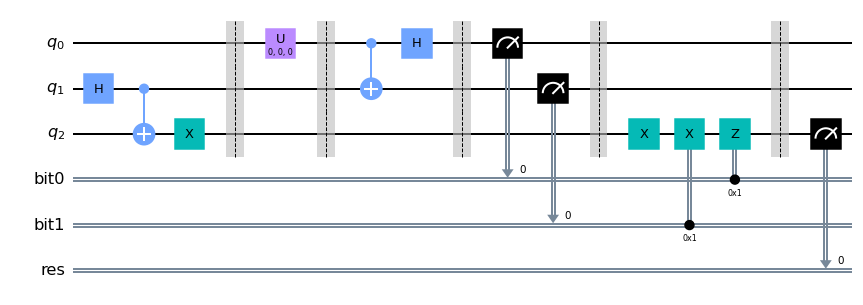

In [54]:
def teleport(u_gate_params=[0,0,0]):
    qr = QuantumRegister(3, name="q")
    bit0 = ClassicalRegister(1, name="bit0")
    bit1 = ClassicalRegister(1, name="bit1")
    res = ClassicalRegister(1, name="res")
    qc = QuantumCircuit(qr, bit0, bit1, res)
    # create EPR pair between Alice and Bob
    qc.h(1)
    qc.cx(1,2)
    qc.x(2)
    qc.barrier()
    # Alice prepares a state to teleport--assuming she doesn't know the parameters
    qc.u(*u_gate_params,0)
    qc.barrier()
    # Alice transforms for measurement
    qc.cx(0,1)
    qc.h(0)
    qc.barrier()
    # Alice performs measurements and sends values to Bob via classical channel
    qc.measure(0,0)
    qc.measure(1,1)
    qc.barrier()
    # Bob performs conditional operations based on classical bits
    qc = bobs_operations(qc)
    qc.barrier()
    # measure on Bob's transformed state
    qc.measure(2,2)
    return qc

def bobs_operations(qc):
    # here's the classical bits sent from Alice
    bit_0 = qc.cregs[0]
    bit_1 = qc.cregs[1]
    # you fill in the rest ...
    # BEGIN SOLUTION
    # hint: use property that gates are their own inverses, so apply XX or ZZ when we don't want to use gate
    # hint: 00:XZ, 01:Z, 10:X, 11:nothing <-- alice-bits:bob-operations
    qc.x(2)
    qc.x(2).c_if(bit_1, 1)
    qc.z(2).c_if(bit_0, 1)
    # END SOLUTION
    return qc

teleport().draw(output='mpl')

In [55]:
def testKet0():
    sim = BasicAer.get_backend("qasm_simulator")
    qc = teleport()
    job = execute(qc, sim)
    counts = job.result().get_counts()
    zero = 0
    for k, v in counts.items():
        if int(k[0]) == 0:
            zero += v
    return zero == 1024

testKet0()

True

In [56]:
def testKet1():
    sim = BasicAer.get_backend("qasm_simulator")
    qc = teleport(u_gate_params=[np.pi,0,np.pi])
    job = execute(qc, sim)
    counts = job.result().get_counts()
    one = 0
    for k, v in counts.items():
        if int(k[0]) == 1:
            one += v
    return one == 1024

testKet1()

True

In [57]:
def testRandomParams():
    sim = BasicAer.get_backend("qasm_simulator")
    qc = teleport(u_gate_params=[131*np.pi/240,247*np.pi/332,347*np.pi/468])
    job = execute(qc, sim, shots=10000)
    counts = job.result().get_counts()
    zero = 0
    for k, v in counts.items():
        zero += v if int(k[0]) == 0 else 0
    return zero > 3900 and zero < 4550

testRandomParams()

True

#### Task 4B
So your circuit passes the tests, but what fun is that? Let's visualize it.
- Create a teleportation instance where the teleported state is `25%` likely to be measured as $|1\rangle$ by Bob
- Store your measurements in `counts` and use the provided code to create a histogram that shows that your circuit meets the target ratio

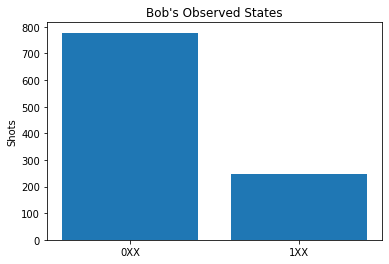

In [58]:
# BEGIN SOLUTION
# students made this U gate in Qiskit 1
sim = BasicAer.get_backend("qasm_simulator")
u_gate_params=[np.pi/3, 0, 0]
qc = teleport(u_gate_params)
job = execute(qc, sim)
counts = job.result().get_counts()
# END SOLUTION

zero = 0
one = 0
for k, v in counts.items():
    if int(k[0]) == 0:
        zero += v
    else:
        one += v 

y = np.arange(2)
plt.bar(y, [zero, one])
plt.ylabel("Shots")
plt.xticks(y, ["0XX", "1XX"])
plt.title("Bob's Observed States")
plt.show()

That's all for today.

Next time: quantum games!